In [1]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_color_value,
    reconstruct_image_from_general,
    plot_full,
    find_nearest_edge,
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    get_width_info,
    get_width_info_new,
)
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    find_node_equ,
)
import pandas as pd
from amftrack.pipeline.functions.spore_processing.spore_id import make_spore_data
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    resolve_anastomosis_crossing_by_root,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
    Edge,
    Hyphae,
    get_distance,
)
from amftrack.util.sys import (
    get_analysis_folders,
    get_time_plate_info_from_analysis,
    get_time_hypha_info_from_analysis,
    get_global_hypha_info_from_analysis,
)

from datetime import datetime
from matplotlib import cm
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from IPython.display import clear_output
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-07-16 22:48:34.716160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 22:48:35.280305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home2/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/cv2/../../lib64:
2023-07-16 22:48:35.280370: I tensorflow/stream_executor/cuda/cudart_stub.cc:29

In [2]:
def get_time(exp, t, tp1):  # redefined here to avoid loop in import
    seconds = (exp.dates[tp1] - exp.dates[t]).total_seconds()
    return seconds / 3600

In [3]:
plates = ["94_20201123"]
directory_targ = directory_project
directory_targ = os.path.join(directory_scratch, "stitch_temp2") + "/"
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(plates)]
# update_plate_info(directory_targ, local=True)
# all_folders = get_current_folders(directory_targ, local=True)

In [ ]:
"""Utils for defining environement variables and defining paths"""

from scipy import sparse
import numpy as np
import os
from datetime import datetime
from amftrack.pipeline.functions.image_processing.extract_graph import (
    sparse_to_doc,
)
import cv2
import json
import pandas as pd
from amftrack.util.dbx import download, upload, load_dbx, env_config
from tqdm.autonotebook import tqdm
from time import time_ns
from decouple import Config, RepositoryEnv
from pymatreader import read_mat
import shutil
import hashlib

from amftrack.util.sys import *




def pad_number(number):
    """
    Convert number to string and padd with a zero
    Ex:
    1 -> 01
    23 -> 23
    """
    if number < 10:
        return f"0{number}"
    else:
        return str(number)


def get_path(date, plate, skeleton, row=None, column=None, extension=".mat"):
    root_path = (
        r"//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE"
    )
    date_plate = f"/2020{date}"
    plate = f"_Plate{plate}"
    if skeleton:
        end = "/Analysis/Skeleton" + extension
    else:
        end = "/Img" + f"/Img_r{pad_number(row)}_c{pad_number(column)}.tif"
    return root_path + date_plate + plate + end


def get_dates_datetime(directory, plate):
    listdir = os.listdir(directory)
    list_dir_interest = [
        name
        for name in listdir
        if name.split("_")[-1] == f'Plate{0 if plate<10 else ""}{plate}'
    ]
    ss = [name.split("_")[0] for name in list_dir_interest]
    ff = [name.split("_")[1] for name in list_dir_interest]
    dates_datetime = [
        datetime(
            year=int(ss[i][:4]),
            month=int(ss[i][4:6]),
            day=int(ss[i][6:8]),
            hour=int(ff[i][0:2]),
            minute=int(ff[i][2:4]),
        )
        for i in range(len(list_dir_interest))
    ]
    dates_datetime.sort()
    return dates_datetime


def get_dirname(date, folders):
    select = folders.loc[folders["datetime"] == date]["folder"]
    assert len(select) == 1
    return select.iloc[0]


def shift_skeleton(skeleton, shift):
    shifted_skeleton = sparse.dok_matrix(skeleton.shape, dtype=bool)
    for pixel in skeleton.keys():
        #             print(pixel[0]+shift[0],pixel[1]+shift[1])
        if (
            skeleton.shape[0] > np.ceil(pixel[0] + shift[0]) > 0
            and skeleton.shape[1] > np.ceil(pixel[1] + shift[1]) > 0
        ):
            shifted_pixel = (
                np.round(pixel[0] + shift[0]),
                np.round(pixel[1] + shift[1]),
            )
            shifted_skeleton[shifted_pixel] = 1
    return shifted_skeleton


def transform_skeleton_final_for_show(skeleton_doc, Rot, trans):
    skeleton_transformed = {}
    transformed_keys = np.round(
        np.transpose(np.dot(Rot, np.transpose(np.array(list(skeleton_doc.keys())))))
        + trans
    ).astype(np.int)
    i = 0
    for pixel in list(transformed_keys):
        i += 1
        skeleton_transformed[(pixel[0], pixel[1])] = 1
    skeleton_transformed_sparse = sparse.lil_matrix((27000, 60000))
    for pixel in list(skeleton_transformed.keys()):
        i += 1
        skeleton_transformed_sparse[(pixel[0], pixel[1])] = 1
    return skeleton_transformed_sparse


def get_skeleton(exp, boundaries, t, directory):
    i = t
    plate = exp.prince_pos
    listdir = os.listdir(directory)
    dates = exp.dates
    date = dates[i]
    directory_name = get_dirname(date, exp.folders)
    path_snap = directory + directory_name
    skel = read_mat(path_snap + "/Analysis/skeleton_pruned_realigned.mat")
    skelet = skel["skeleton"]
    skelet = sparse_to_doc(skelet)
    Rot = skel["R"]
    trans = skel["t"]
    skel_aligned = transform_skeleton_final_for_show(
        skelet, np.array([[1, 0], [0, 1]]), np.array([0, 0])
    )
    output = skel_aligned[
        boundaries[2] : boundaries[3], boundaries[0] : boundaries[1]
    ].todense()
    kernel = np.ones((5, 5), np.uint8)
    output = cv2.dilate(output.astype(np.uint8), kernel, iterations=2)
    return (output, Rot, trans)


def get_param(
    folder, directory
):  # Very ugly but because interfacing with Matlab so most elegant solution.
    # TODO(FK)
    path_snap = os.path.join(directory, folder)
    file1 = open(os.path.join(path_snap, "param.m"), "r")
    Lines = file1.readlines()
    ldict = {}
    for line in Lines:
        to_execute = line.split(";")[0]
        relation = to_execute.split("=")
        if len(relation) == 2:
            ldict[relation[0].strip()] = relation[1].strip()
        # exec(line.split(';')[0],globals(),ldict)
    files = [
        "/Img/TileConfiguration.txt.registered",
        "/Analysis/skeleton_compressed.mat",
        "/Analysis/skeleton_masked_compressed.mat",
        "/Analysis/skeleton_pruned_compressed.mat",
        "/Analysis/transform.mat",
        "/Analysis/transform_corrupt.mat",
        "/Analysis/skeleton_realigned_compressed.mat",
        "/Analysis/nx_graph_pruned.p",
        "/Analysis/nx_graph_pruned_width.p",
        "/Analysis/nx_graph_pruned_labeled.p",
    ]
    for file in files:
        ldict[file] = os.path.isfile(path_snap + file)  # TODO(FK) change here
    return ldict


def update_plate_info_local(directory: str) -> None:
    """
    An acquisition repositorie has a param.m file inside it.
    :param directory: full path to a directory containing acquisition directories
    """
    target = env_config.get("DATA_PATH")
    listdir = os.listdir(directory)
    info_path = os.path.join(storage_path, "data_info.json")
    # TODO(FK): Crashes when there is no basic file
    # try:
    #     with open(target) as f:
    #         plate_info = json.load(f)
    # except:
    #     s = "/home/ipausers/kahane/Wks/AMFtrack/template_data_info.json"
    #     dest = os.path.join(storage_path, "data_info.json")
    #     shutil.copy(s, dest)
    #     with open(target) as f:
    #         plate_info = json.load(f)
    with open(info_path) as f:
        plate_info = json.load(f)

    # TOFIX
    for folder in listdir:
        if os.path.isfile(os.path.join(directory, folder, "param.m")):
            params = get_param(folder, directory)
            ss = folder.split("_")[0]
            ff = folder.split("_")[1]
            date = datetime(
                year=int(ss[:4]),
                month=int(ss[4:6]),
                day=int(ss[6:8]),
                hour=int(ff[0:2]),
                minute=int(ff[2:4]),
            )
            params["date"] = datetime.strftime(date, "%d.%m.%Y, %H:%M:")
            params["folder"] = folder
            total_path = os.path.join(directory, folder)
            plate_info[total_path] = params
    with open(target, "w") as jsonf:
        json.dump(plate_info, jsonf, indent=4)


def update_plate_info(
    directory: str, local=True, strong_constraint=True, suffix_data_info=""
) -> None:
    """*
    1/ Download `data_info.json` file containing all information about acquisitions.
    2/ Add all acquisition files in the `directory` path to the `data_info.json`.
    3/ Upload the new version of data_info (actuliased) to the dropbox.
    An acquisition repositorie has a param.m file inside it.
    """
    # TODO(FK): add a local version without dropbox modification
    listdir = os.listdir(directory)
    source = f"/data_info.json"
    target = os.path.join(temp_path, f"data_info{suffix_data_info}.json")
    if local:
        plate_info = {}
    else:
        download(source, target, end="")
        plate_info = json.load(open(target, "r"))
    with tqdm(total=len(listdir), desc="analysed") as pbar:
        for folder in listdir:
            path_snap = os.path.join(directory, folder)
            if os.path.exists(os.path.join(path_snap, "Img")):
                sub_list_files = os.listdir(os.path.join(path_snap, "Img"))
                is_real_folder = os.path.isfile(os.path.join(path_snap, "param.m"))
                if strong_constraint:
                    is_real_folder *= (
                        os.path.isfile(
                            os.path.join(path_snap, "Img", "Img_r03_c05.tif")
                        )
                        * len(sub_list_files)
                        >= 100
                    )
                if is_real_folder:
                    params = get_param(folder, directory)
                    ss = folder.split("_")[0]
                    ff = folder.split("_")[1]
                    date = datetime(
                        year=int(ss[:4]),
                        month=int(ss[4:6]),
                        day=int(ss[6:8]),
                        hour=int(ff[0:2]),
                        minute=int(ff[2:4]),
                    )
                    params["date"] = datetime.strftime(date, "%d.%m.%Y, %H:%M:")
                    params["folder"] = folder
                    total_path = os.path.join(directory, folder)
                    plate_info[total_path] = params
            pbar.update(1)
    with open(target, "w") as jsonf:
        json.dump(plate_info, jsonf, indent=4)
    if not local:
        upload(target, f"{source}", chunk_size=256 * 1024 * 1024)


def get_data_info(local=False, suffix_data_info=""):
    source = f"/data_info.json"
    target = os.path.join(temp_path, f"data_info{suffix_data_info}.json")

    if not local:
        download(source, target, end="")
    data_info = pd.read_json(target, convert_dates=True).transpose()
    if len(data_info) > 0:
        data_info.index.name = "total_path"
        data_info.reset_index(inplace=True)
        data_info["unique_id"] = (
            data_info["Plate"].astype(str).astype(int).astype(str)
            + "_"
            + data_info["CrossDate"].str.replace("'", "").astype(str)
        )

        data_info["datetime"] = pd.to_datetime(
            data_info["date"], format="%d.%m.%Y, %H:%M:"
        )
    return data_info


def get_current_folders_local(directory: str) -> pd.DataFrame:
    """
    :param directory: full path to a directory containing acquisition files
    """
    plate_info = pd.read_json(
        os.path.join(storage_path, "data_info.json"), convert_dates=True
    ).transpose()
    plate_info.index.name = "total_path"
    plate_info.reset_index(inplace=True)
    listdir = os.listdir(directory)
    selected_df = plate_info.loc[
        np.isin(plate_info["folder"], listdir)  # folder exist
        & (
            plate_info["total_path"]
            == plate_info["folder"].apply(
                lambda x: os.path.join(directory, x)
            )  # folder is registered
        )
    ]
    return selected_df


def get_current_folders(
    directory: str, local=True, suffix_data_info=""
) -> pd.DataFrame:
    """
    Returns a pandas data frame with all informations about the acquisition files
    inside the directory.
    WARNING: directory must finish with '/'
    """
    # TODO(FK): solve the / problem
    plate_info = get_data_info(local, suffix_data_info)
    listdir = os.listdir(directory)
    if len(plate_info) > 0:
        return plate_info.loc[
            np.isin(plate_info["folder"], listdir)
            & (plate_info["total_path"] == directory + plate_info["folder"])
        ]
    else:
        return plate_info


def get_folders_by_plate_id(plate_id, begin=0, end=-1, directory=None):
    data_info = get_data_info() if directory is None else get_current_folders(directory)
    folders = data_info.loc[
        10**8 * data_info["Plate"] + data_info["CrossDate"] == plate_id
    ]
    dates_datetime = [
        datetime.strptime(row["date"], "%d.%m.%Y, %H:%M:")
        for index, row in folders.iterrows()
    ]
    dates_datetime.sort()
    dates_datetime_select = dates_datetime[begin:end]
    dates_str = [
        datetime.strftime(date, "%d.%m.%Y, %H:%M:") for date in dates_datetime_select
    ]
    select_folders = folders.loc[np.isin(folders["date"], dates_str)]
    return select_folders


def update_analysis_info(directory, suffix_analysis_info=""):
    listdir = os.listdir(directory)
    analysis_dir = [fold for fold in listdir if fold.split("_")[0] == "Analysis"]
    infos_analysed = {}
    for folder in analysis_dir:
        metadata = {}
        version = folder.split("_")[-1]
        op_id = int(folder.split("_")[-2])
        dt = datetime.fromtimestamp(op_id // 1000000000)
        path = f"{directory}{folder}/folder_info.json"
        if os.path.exists(path):
            infos = pd.read_json(path, dtype={"unique_id": str})
            if len(infos) > 0:
                column_interest = [
                    column for column in infos.columns if column[0] != "/"
                ]
                metadata["version"] = version
                for column in column_interest:
                    if column != "folder":
                        info = str(infos[column].iloc[0])
                        metadata[column] = info
                metadata["date_begin"] = datetime.strftime(
                    infos["datetime"].iloc[0], "%d.%m.%Y, %H:%M:"
                )
                metadata["date_end"] = datetime.strftime(
                    infos["datetime"].iloc[-1], "%d.%m.%Y, %H:%M:"
                )
                metadata["number_timepoints"] = len(infos)
                metadata["path_exp"] = f"{folder}/experiment.pick"
                metadata["path_global_hypha_info"] = f"{folder}/global_hypha_info.json"
                metadata["path_time_hypha_info"] = f"{folder}/time_hypha_info"
                metadata["path_time_plate_info"] = f"{folder}/time_plate_info.json"
                metadata["path_global_plate_info"] = f"{folder}/global_plate_info.json"
                metadata["date_run_analysis"] = datetime.strftime(
                    dt, "%d.%m.%Y, %H:%M:"
                )
                infos_analysed[folder] = metadata
        else:
            print(folder)
    target = os.path.join(temp_path, f"analysis_info{suffix_analysis_info}.json")

    with open(target, "w") as jsonf:
        json.dump(infos_analysed, jsonf, indent=4)


def get_analysis_info(directory, suffix_analysis_info=""):
    target = os.path.join(temp_path, f"analysis_info{suffix_analysis_info}.json")

    analysis_info = pd.read_json(target, convert_dates=True).transpose()
    analysis_info.index.name = "folder_analysis"
    analysis_info.reset_index(inplace=True)
    return analysis_info


def get_analysis_folders(path=dropbox_path):
    analysis_folders = pd.DataFrame()
    for dire in os.walk(path):
        name_analysis = dire[0].split(os.sep)[-1].split("_")
        if name_analysis[0] == "Analysis":
            analysis_dir = dire[0]
            path_save = os.path.join(analysis_dir, "folder_info.json")
            if os.path.exists(path_save):
                folders_plate = pd.read_json(path_save)
                infos = folders_plate.iloc[0][1:10]
                infos["total_path"] = analysis_dir
                infos["time_plate"] = os.path.isfile(
                    os.path.join(analysis_dir, "time_plate_info.json")
                )
                infos["global_hypha"] = os.path.isfile(
                    os.path.join(analysis_dir, "global_hypha_info.json")
                )
                infos["time_hypha"] = os.path.isdir(
                    os.path.join(analysis_dir, "time_hypha_info.json")
                )

                infos["num_folders"] = len(folders_plate)
                analysis_folders = pd.concat([analysis_folders, infos], axis=1)

    analysis_folders = analysis_folders.transpose().reset_index().drop("index", axis=1)
    analysis_folders["unique_id"] = (
        analysis_folders["Plate"].astype(str)
        + "_"
        + analysis_folders["CrossDate"].astype(str).str.replace("'", "")
    )
    return analysis_folders


def get_time_plate_info_from_analysis(analysis_folders, use_saved=True):
    plates_in = analysis_folders["unique_id"].unique()
    plates_in.sort()
    ide = hashlib.sha256(np.sum(plates_in).encode("utf-8")).hexdigest()
    path_save_info = os.path.join(temp_path, f"time_plate_info_{ide}")
    path_save_folders = os.path.join(temp_path, f"folders_{ide}")

    if os.path.exists(path_save_info) and use_saved:
        time_plate_info = pd.read_json(path_save_info)
        folders = pd.read_json(path_save_folders)
        return (folders, time_plate_info)
    analysis_dirs = analysis_folders["total_path"]
    time_plate_info = pd.DataFrame()
    folders = pd.DataFrame()
    for analysis_dir in analysis_dirs:
        path_save = os.path.join(analysis_dir, "time_plate_info.json")
        table = pd.read_json(path_save)
        table = table.transpose()
        table = table.fillna(-1)
        path_save = os.path.join(analysis_dir, "folder_info.json")
        folders_plate = pd.read_json(path_save)
        folders_plate = folders_plate.reset_index()
        table = pd.concat(
            (table, (folders_plate["datetime"] - folders_plate["datetime"].iloc[0])),
            axis=1,
        )
        table = table.rename(columns={"datetime": "time_since_begin"})
        table["time_since_begin_h"] = table["time_since_begin"].copy() / np.timedelta64(
            1, "h"
        )
        table = pd.concat((table, pd.DataFrame(folders_plate.index.values)), axis=1)
        table = table.rename(columns={0: "timestep"})
        table = pd.concat((table, (folders_plate["folder"])), axis=1)
        table = pd.concat((table, (folders_plate["unique_id"])), axis=1)
        table = pd.concat((table, (folders_plate["datetime"])), axis=1)
        for column in ["PrincePos", "root", "strain", "medium"]:
            try:
                table = pd.concat((table, (folders_plate[column])), axis=1)
            except KeyError:
                continue
        time_plate_info = pd.concat([time_plate_info, table], ignore_index=True)
        folders = pd.concat(
            [folders.copy(), folders_plate.copy()], axis=0, ignore_index=True
        )
    time_plate_info.to_json(path_save_info)
    folders.to_json(path_save_folders)
    return (folders, time_plate_info)


def get_global_hypha_info_from_analysis(analysis_folders, use_saved=True):
    plates_in = analysis_folders["unique_id"].unique()
    plates_in.sort()
    ide = hashlib.sha256(np.sum(plates_in).encode("utf-8")).hexdigest()
    path_save_info = os.path.join(temp_path, f"global_hypha_info_{ide}")
    path_save_folders = os.path.join(temp_path, f"folders_{ide}")

    if os.path.exists(path_save_info) and use_saved:
        global_hypha_info = pd.read_json(path_save_info)
        folders = pd.read_json(path_save_folders)
        return (folders, global_hypha_info)
    analysis_dirs = analysis_folders["total_path"]
    global_hypha_info = pd.DataFrame()
    folders = pd.DataFrame()
    for analysis_dir in analysis_dirs:
        path_save = os.path.join(analysis_dir, "global_hypha_info.json")
        if os.path.exists(path_save):
            table = pd.read_json(path_save)
            table = table.transpose()
            table = table.fillna(-1)
            path_save = os.path.join(analysis_dir, "folder_info.json")
            folders_plate = pd.read_json(path_save)
            folders_plate = folders_plate.reset_index()
            table = table.reset_index()
            table["unique_id"] = folders_plate["unique_id"].iloc[0]
            table["PrincePos"] = folders_plate["PrincePos"].iloc[0]
            table["root"] = folders_plate["root"].iloc[0]
            table["strain"] = folders_plate["strain"].iloc[0]
            table["medium"] = folders_plate["medium"].iloc[0]
            global_hypha_info = pd.concat([global_hypha_info, table], ignore_index=True)
            folders = pd.concat(
                [folders.copy(), folders_plate.copy()], axis=0, ignore_index=True
            )
    global_hypha_info.to_json(path_save_info)
    folders.to_json(path_save_folders)
    return (folders, global_hypha_info)


def get_time_hypha_info_from_analysis(analysis_folders, use_saved=True):
    plates_in = analysis_folders["unique_id"].unique()
    plates_in.sort()
    ide = hashlib.sha256(np.sum(plates_in).encode("utf-8")).hexdigest()
    path_save_info = os.path.join(temp_path, f"time_hypha_info_{ide}")
    path_save_folders = os.path.join(temp_path, f"folders_{ide}")

    if os.path.exists(path_save_info) and use_saved:
        time_hypha_infos = pd.read_json(path_save_info)
        folders = pd.read_json(path_save_folders)
        return (folders, time_hypha_infos)
    analysis_dirs = analysis_folders["total_path"]
    folders = pd.DataFrame()
    time_hypha_infos = []
    for analysis_dir in analysis_dirs:
        path_time_hypha = os.path.join(analysis_dir, "time_hypha_info")
        if os.path.exists(path_time_hypha):
            path_save = os.path.join(analysis_dir, "folder_info.json")
            folders_plate = pd.read_json(path_save)
            folders_plate = folders_plate.reset_index()
            folders_plate = folders_plate.sort_values("datetime")
            json_paths = os.listdir(path_time_hypha)
            tables = []
            for path in json_paths:
                print(path)
                index = int(path.split("_")[-1].split(".")[0])
                line = folders_plate.iloc[index]
                try:
                    table = pd.read_json(os.path.join(path_time_hypha, path))
                except:
                    print(os.path.join(path_time_hypha, path))
                    continue
                table = table.transpose()
                table = table.fillna(-1)
                table["time_since_begin_h"] = (
                    line["datetime"] - folders_plate["datetime"].iloc[0]
                )
                table["folder"] = line["folder"]
                table["Plate"] = line["Plate"]
                table["unique_id"] = line["unique_id"]
                table["datetime"] = line["datetime"]
                table["PrincePos"] = line["PrincePos"]
                table["root"] = line["root"]
                table["strain"] = line["strain"]
                table["medium"] = line["medium"]
                tables.append(table)
            time_hypha_info_plate = pd.concat(tables, axis=0, ignore_index=True)
            time_hypha_info_plate.reset_index(inplace=True, drop=True)
            time_hypha_infos.append(time_hypha_info_plate)
            folders = pd.concat([folders, folders_plate], axis=0, ignore_index=True)
    time_hypha_info = pd.concat(time_hypha_infos, axis=0, ignore_index=True)
    time_hypha_info.to_json(path_save_info)
    folders.to_json(path_save_folders)
    return (folders, time_hypha_info)


def get_time_edge_info_from_analysis(analysis_folders, use_saved=True):
    plates_in = analysis_folders["unique_id"].unique()
    plates_in.sort()
    ide = hashlib.sha256(np.sum(plates_in).encode("utf-8")).hexdigest()
    path_save_info = os.path.join(temp_path, f"time_edge_info_{ide}")
    path_save_folders = os.path.join(temp_path, f"folders_{ide}")

    if os.path.exists(path_save_info) and use_saved:
        time_edge_infos = pd.read_json(path_save_info)
        folders = pd.read_json(path_save_folders)
        return (folders, time_edge_infos)
    analysis_dirs = analysis_folders["total_path"]
    folders = pd.DataFrame()
    time_edge_infos = []
    for analysis_dir in analysis_dirs:
        path_time_edge = os.path.join(analysis_dir, "time_edge_info")
        if os.path.exists(path_time_edge):
            path_save = os.path.join(analysis_dir, "folder_info.json")
            folders_plate = pd.read_json(path_save)
            folders_plate = folders_plate.reset_index()
            folders_plate = folders_plate.sort_values("datetime")
            json_paths = os.listdir(path_time_edge)
            tables = []
            for path in json_paths:
                index = int(path.split("_")[-1].split(".")[0])
                line = folders_plate.iloc[index]
                try:
                    table = pd.read_json(os.path.join(path_time_edge, path))
                except:
                    print(os.path.join(path_time_edge, path))
                    continue
                table = table.transpose()
                table = table.fillna(-1)
                table["time_since_begin_h"] = (
                    line["datetime"] - folders_plate["datetime"].iloc[0]
                )
                table["folder"] = line["folder"]
                table["Plate"] = line["Plate"]
                table["unique_id"] = line["unique_id"]
                table["datetime"] = line["datetime"]
                for column in ["PrincePos", "root", "strain", "medium"]:
                    try:
                        table[column] = line[column]
                    except KeyError:
                        continue

                tables.append(table)
            time_edge_info_plate = pd.concat(tables, axis=0, ignore_index=True)
            time_edge_info_plate.reset_index(inplace=True, drop=True)
            time_edge_infos.append(time_edge_info_plate)
            folders = pd.concat([folders, folders_plate], axis=0, ignore_index=True)
    time_edge_info = pd.concat(time_edge_infos, axis=0, ignore_index=True)
    time_edge_info.to_json(path_save_info)
    folders.to_json(path_save_folders)
    return (folders, time_edge_info)


def get_time_plate_info_long_from_analysis(analysis_folders, use_saved=True):
    plates_in = analysis_folders["unique_id"].unique()
    plates_in.sort()
    ide = hashlib.sha256(np.sum(plates_in).encode("utf-8")).hexdigest()
    path_save_info = os.path.join(temp_path, f"time_plate_info_long_{ide}")
    path_save_folders = os.path.join(temp_path, f"folders_{ide}")

    if os.path.exists(path_save_info) and use_saved:
        time_plate_infos = pd.read_json(path_save_info)
        folders = pd.read_json(path_save_folders)
        return (folders, time_plate_infos)
    analysis_dirs = analysis_folders["total_path"]
    folders = pd.DataFrame()
    time_plate_infos = []
    for analysis_dir in analysis_dirs:
        path_time_plate = os.path.join(analysis_dir, "time_plate_info_long")
        if os.path.exists(path_time_plate):
            path_save = os.path.join(analysis_dir, "folder_info.json")
            folders_plate = pd.read_json(path_save)
            folders_plate = folders_plate.reset_index()
            folders_plate = folders_plate.sort_values("datetime")
            json_paths = os.listdir(path_time_plate)
            tables = []
            for path in json_paths:
                index = int(path.split("_")[-1].split(".")[0])
                line = folders_plate.iloc[index]
                try:
                    table = pd.read_json(
                        os.path.join(path_time_plate, path), orient="index"
                    )
                except:
                    print(os.path.join(path_time_plate, path))
                    continue
                table = table.transpose()
                table = table.fillna(-1)
                table["time_since_begin_h"] = (
                    line["datetime"] - folders_plate["datetime"].iloc[0]
                )
                table["folder"] = line["folder"]
                table["Plate"] = line["Plate"]
                table["unique_id"] = line["unique_id"]
                table["datetime"] = line["datetime"]
                for column in ["PrincePos", "root", "strain", "medium"]:
                    try:
                        table[column] = line[column]
                    except KeyError:
                        continue

                tables.append(table)
            time_plate_info_plate = pd.concat(tables, axis=0, ignore_index=True)
            time_plate_info_plate = time_plate_info_plate.sort_values("datetime")
            time_plate_info_plate.reset_index(inplace=True, drop=True)
            time_plate_info_plate["timestep"] = time_plate_info_plate.index

            time_plate_infos.append(time_plate_info_plate)
            folders = pd.concat([folders, folders_plate], axis=0, ignore_index=True)
    time_plate_info = pd.concat(time_plate_infos, axis=0, ignore_index=True)
    time_plate_info.to_json(path_save_info)
    folders.to_json(path_save_folders)
    return (folders, time_plate_info)


def get_data_tables(op_id=time_ns(), redownload=True):
    API = str(np.load(os.getenv("HOME") + "/pycode/API_drop.npy"))
    dir_drop = "data_tables"
    root = os.getenv("TEMP")
    # op_id = time_ns()
    if redownload:
        path_save = f"{root}global_hypha_info{op_id}.pick"
        download(f"/{dir_drop}/global_hypha_infos.pick", path_save)
        path_save = f"{root}time_plate_infos{op_id}.pick"
        download(f"/{dir_drop}/time_plate_infos.pick", path_save)
        path_save = f"{root}time_hypha_info{op_id}.pick"
        download(f"/{dir_drop}/time_hypha_infos.pick", path_save)
    path_save = f"{root}time_plate_infos{op_id}.pick"
    time_plate_info = pd.read_pickle(path_save)
    path_save = f"{root}global_hypha_info{op_id}.pick"
    global_hypha_info = pd.read_pickle(path_save)
    path_save = f"{root}time_hypha_info{op_id}.pick"
    time_hypha_info = pd.read_pickle(path_save)
    return (time_plate_info, global_hypha_info, time_hypha_info)



In [4]:
all_analysis_folders = get_analysis_folders(directory_targ)
analysis_folders_info = all_analysis_folders.loc[
    all_analysis_folders["unique_id"].isin(plates)
]
folders, time_plate_info = get_time_plate_info_from_analysis(
    analysis_folders_info, use_saved=False
)
folders, time_hypha_info = get_time_hypha_info_from_analysis(
    analysis_folders_info, use_saved=False
)

In [6]:
path_exp = f'{directory_targ}{analysis_folders["path_exp"].iloc[0]}'
exp = pickle.load(open(path_exp, "rb"))
exp.save_location = "/"
try:
    exp.labeled
except AttributeError:
    exp.labeled = True
load_graphs(exp, directory_targ, indexes=range(90, 92))
# load_graphs(exp, directory_targ, indexes=[90, 70, 60])

load_study_zone(exp)

In [ ]:
for t in range(exp.ts):
    exp.load_tile_information(t)
im = exp.get_image(0, 0)
exp.dimX_dimY = im.shape

In [150]:
list_hyph = [0, 6, 118, 58, 1, 85]
# list_hyph = [521770,535353,509730]
# list_hyph = [509730]
# list_hyph = [1]

In [21]:
hyph = [hyph for hyph in exp.hyphaes if hyph.end.label == 0][0]
hyph.root = Node(44, exp)
hyph = [hyph for hyph in exp.hyphaes if hyph.end.label == 6][0]
hyph.root = Node(147, exp)

In [22]:
tf = 90

# list_hyph = [hyph for hyph in exp.hyphaes if hyph.end.is_in(hyph.ts[-1]) and np.linalg.norm(hyph.end.pos(hyph.ts[-1])-hyph.get_root(hyph.ts[-1]).pos(hyph.ts[-1]))>=1e3]
list_hyph_obj = [
    hyph
    for hyph in exp.hyphaes
    if hyph.end.is_in(tf)
    and len(hyph.root.ts()) >= 1
    # and np.linalg.norm(hyph.end.pos(tf) - hyph.get_root(tf).pos(tf)) >= 1e4
    and len(hyph.end.ts())>3
    and np.linalg.norm(hyph.end.pos(hyph.end.ts()[0]) - hyph.end.pos(hyph.end.ts()[-1])) >= 1000
]
list_hyph_tot = [hyph.end.label for hyph in list_hyph_obj]

In [23]:
list_hyph = list_hyph_tot


In [24]:
list_hyph

[0, 1, 6, 58, 85, 118, 213, 558274, 562921]

In [46]:
from random import choice

list_hyph = [choice(list_hyph_tot)]
list_hyph

[562921]

In [7]:
def get_length_fast(edge, t):
    return np.linalg.norm(edge.begin.pos(t) - edge.end.pos(t))


fbas = lambda edge: np.log(
    edge.width(edge.ts()[-1])
    * edge.length_um(edge.ts()[-1])
    * edge.end.degree(edge.ts()[-1])
    * edge.begin.degree(edge.ts()[-1])
)  # function to evaluate BASness, typical threshold is 10
f = lambda edge: np.log(
    edge.width(edge.ts()[-1])
    * get_length_fast(edge, edge.ts()[-1])
    * edge.end.degree(edge.ts()[-1])
    * edge.begin.degree(edge.ts()[-1])
)  # function to evaluate BASness, typical threshold is 10

In [25]:
actual_list_hyph = []
all_distances = []
all_time_distances = []
tot_junctions = []
tot_lengths = []
tot_speeds=[]
for end in list_hyph:
    hyph_label = end
    hyph = [hyph for hyph in exp.hyphaes if hyph.end.label == end][0]
    t0 = hyph.ts[0]
    if hyph.end.is_in(t0):
        exp = hyph.experiment
        thresh = 1600
        junctions_found = [hyph.end.neighbours(t0)[0]]
        ts = []
        mult = []
        speeds = []
        print(end)
        select = time_hypha_info.loc[time_hypha_info["end"] == end]

        for t in hyph.ts:
            select_t = select.loc[select["timestep"] == t - 1]
            speed = select_t["speed"].iloc[0] if len(select_t) > 0 else -1
            if t < tf:
                try:
                    G = exp.nx_graph[t]
                    G = G.subgraph(nx.node_connected_component(G, hyph.end.label))
                    tim = hyph.end.ts()[-1]
                    tip = hyph.end
                    if hyph.end.degree(t) == 1 and np.linalg.norm(tip.pos(tim) - tip.pos(t)) >= 40:
                        tot_speeds.append(speed)
                        nodes, edges = hyph.get_nodes_within(t)
                        potentials = []
                        nodes = [Node(node, exp) for node in nodes]
                        try:
                            last_junction_index = nodes.index(junctions_found[-1])
                        except:
                            last_junction_index = 0
                        for node in nodes[last_junction_index + 1 : -1]:
                            dist = np.linalg.norm(node.pos(t) - hyph.end.pos(t))
                            # To avoid detecting two times the same  node with different labels
                            dists_junction_found = [np.inf] + [
                                np.linalg.norm(node.pos(t) - nodo.pos(t))
                                for nodo in junctions_found
                                if nodo.is_in(t)
                            ]
                            if (
                                dist < thresh
                                and min(dists_junction_found) > 40
                                and (node not in junctions_found)
                            ):
                                extra_hypha_neighbours = [
                                    nodo for nodo in node.neighbours(t) if nodo not in nodes
                                ]

                                edges = [
                                    Edge(node, nodo, exp) for nodo in extra_hypha_neighbours
                                ]
                                is_rh = [f(edge) >= 10 for edge in edges]
                                tips = [
                                    nodo
                                    for nodo in extra_hypha_neighbours
                                    if nx.edge_connectivity(G, nodo.label, node.label) == 1
                                ]
                                # if len(tips) == node.degree(t) - 2:

                                if len(tips) == node.degree(t) - 2 and np.any(is_rh):
                                    junctions_found.append(node)
                                    mult.append(node.degree(t) - 2)
                                    ts.append(t)
                                    speeds.append(speed)
                # except nx.exception.NetworkXNoPath:
                except:

                    print(hyph, t)


        try:
            junctions_found_tf = [find_node_equ(node, tf) for node in junctions_found]
            junctions_found_tf = [
                node
                for node in junctions_found_tf
                if nx.has_path(exp.nx_graph[tf], node.label, junctions_found_tf[0].label)
            ]
            junctions_found_label = [node.label for node in junctions_found_tf]
            t_real = [get_time(exp, t0, t) for t in ts]
            distances = [
                get_distance(junctions_found_tf[i], junctions_found_tf[i + 1], tf)
                for i in range(1, len(junctions_found_tf) - 1)
            ]
            tot_lengths.append(get_distance(junctions_found_tf[0], hyph.end, tf))
            time_distances = [
                distance / speeds[i + 1] for i, distance in enumerate(distances)
            ]
            all_distances += distances
            all_time_distances += time_distances
            tot_junctions += mult
            np.save(f"branches/ts_{hyph_label}_auto_rh", t_real)
            np.save(f"branches/distances_{hyph_label}_auto_rh", distances)
            np.save(f"branches/times_{hyph_label}_auto_rh", time_distances)

            actual_list_hyph.append(end)
        # except nx.exception.NetworkXNoPath:
        except:

            print("problem with", end)

0
1
6
58
85
(Node(85), Node(60)) 1
(Node(85), Node(60)) 3
(Node(85), Node(60)) 4
118
213
558274
562921


In [209]:
len(tot_speeds)

312

In [26]:
np.mean(tot_speeds)

245.2885319000158

In [27]:
np.sum(tot_junctions)

48

In [28]:
np.sum(tot_lengths)/np.sum(tot_junctions)/np.mean(tot_speeds)

13.964131649603164

In [30]:
1/(np.sum(tot_lengths)/np.sum(tot_junctions)/np.mean(tot_speeds))*24

1.718689038618598

In [ ]:
np.sum(mult)

In [174]:
len([time for time in all_time_distances if not np.isnan(time)])

33

(array([11., 11.,  5.,  2.,  3.,  0.,  0.,  1.]),
 array([ 0.24004585,  3.69837301,  7.15670018, 10.61502734, 14.07335451,
        17.53168167, 20.99000884, 24.44833601, 27.90666317]),
 <BarContainer object of 8 artists>)

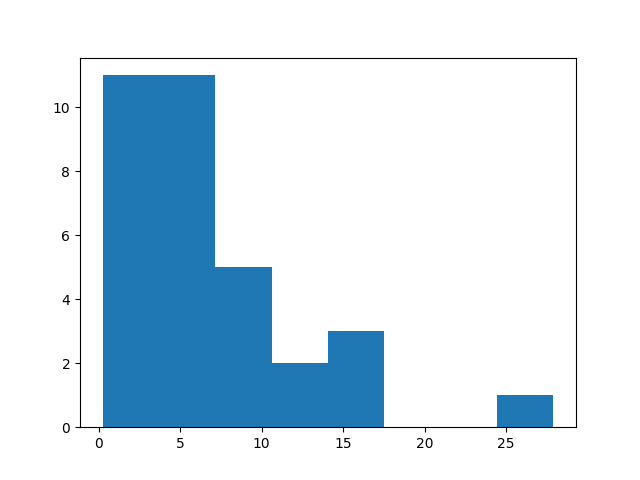

In [162]:
fig, ax = plt.subplots()

ax.hist(all_time_distances, 8)

In [163]:
1/np.nanmean(all_time_distances)

0.14563983933919006

In [ ]:
np.mean(all_time_distances)

In [164]:
all_time_distances

[1.104020656575081,
 16.98219370075514,
 13.172314662318273,
 6.613498949636724,
 4.652750944161508,
 6.68634967123383,
 0.8847369450479917,
 5.91510670258155,
 0.2400458471085538,
 27.906663170656557,
 16.869798576464483,
 8.447558397804183,
 5.456573340151962,
 1.1019315885445562,
 6.2261045656862395,
 0.3532146682680785,
 3.9787973352555537,
 10.482738160533534,
 1.8247279682235,
 9.517396134616734,
 7.602075586390624,
 2.647691838883959,
 2.718615411949019,
 6.902485456881119,
 8.053239676711733,
 0.298656707728387,
 11.909212852831836,
 14.599847115711807,
 2.683713657359033,
 5.442930331284527,
 5.999930358715253,
 3.043725492517472,
 6.26770620213617]

In [59]:
2*0.12/0.22

1.0909090909090908

(array([8., 6., 8., 6., 2., 1., 5., 1., 3., 0., 0., 2.]),
 array([  75.67164153,  747.94695195, 1420.22226237, 2092.49757279,
        2764.77288322, 3437.04819364, 4109.32350406, 4781.59881448,
        5453.8741249 , 6126.14943533, 6798.42474575, 7470.70005617,
        8142.97536659]),
 <BarContainer object of 12 artists>)

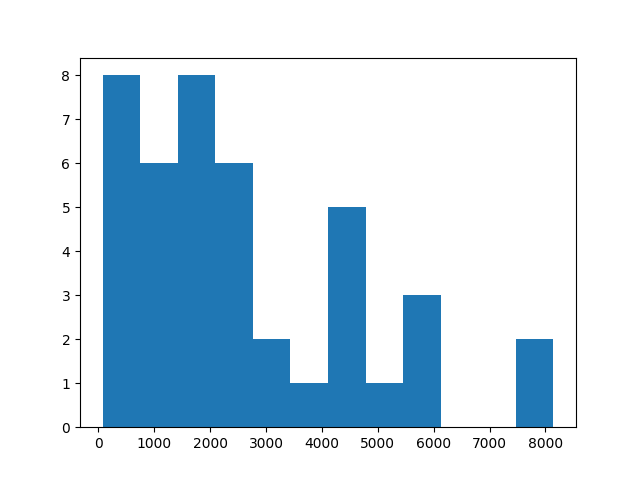

In [14]:
fig, ax = plt.subplots()

ax.hist(all_distances, 12)

In [17]:
tf = 90

list_hyph_obj = [
    hyph for hyph in exp.hyphaes if hyph.end.is_in(tf) and len(hyph.root.ts()) >= 1
]
edges = [hyph.get_nodes_within(tf)[1] for hyph in list_hyph_obj]
edges = [item for sublist in edges for item in sublist]

In [59]:
t = 70
tips = [node for node in get_all_nodes(exp, t) if node.degree(t) == 1]


def h(edge, t):
    boolean = (edge.end.degree(t) == 1 or edge.begin.degree(t) == 1) and edge.length_um(
        t
    ) >= 1000
    # boolean +=((edge.width(t)*edge.length_um(t))<3000)*edge.width(t)<7
    return boolean


edges = get_all_edges(exp, t)
edges = [
    edge
    for edge in edges
    if np.all(is_in_study_zone(edge.begin, t, 1000, 150, is_circle))
]
edges = [
    edge
    for edge in edges
    if np.all(is_in_study_zone(edge.end, t, 1000, 150, is_circle))
]
edge_tip = [edge for edge in edges if h(edge, t)]

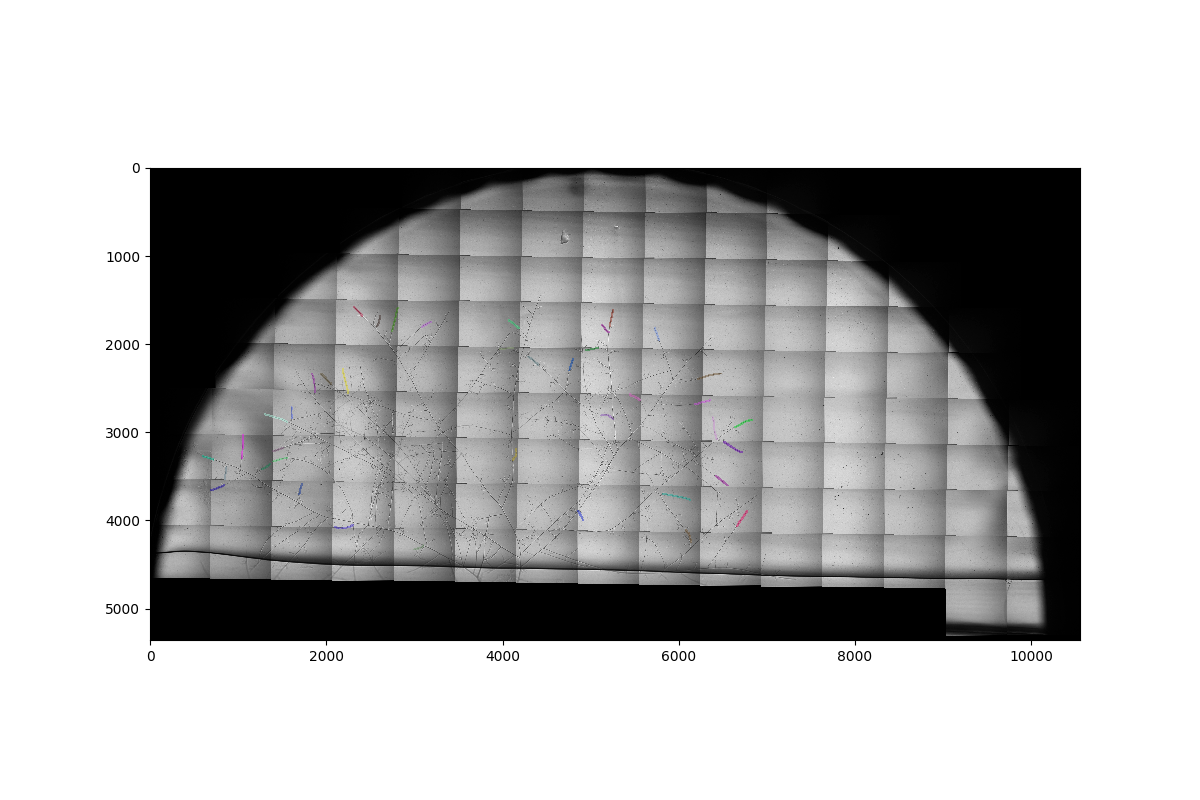

In [60]:
plt.close("all")
exp.load_tile_information(t)

ax = plot_full(
    exp,
    t,
    # nodes = junctions_found_tf
    edges=edge_tip,
    # nodes = tip_disappear,
    dilation=20,
)

In [64]:
params = cv2.SimpleBlobDetector_Params()
params.maxArea

5000.0

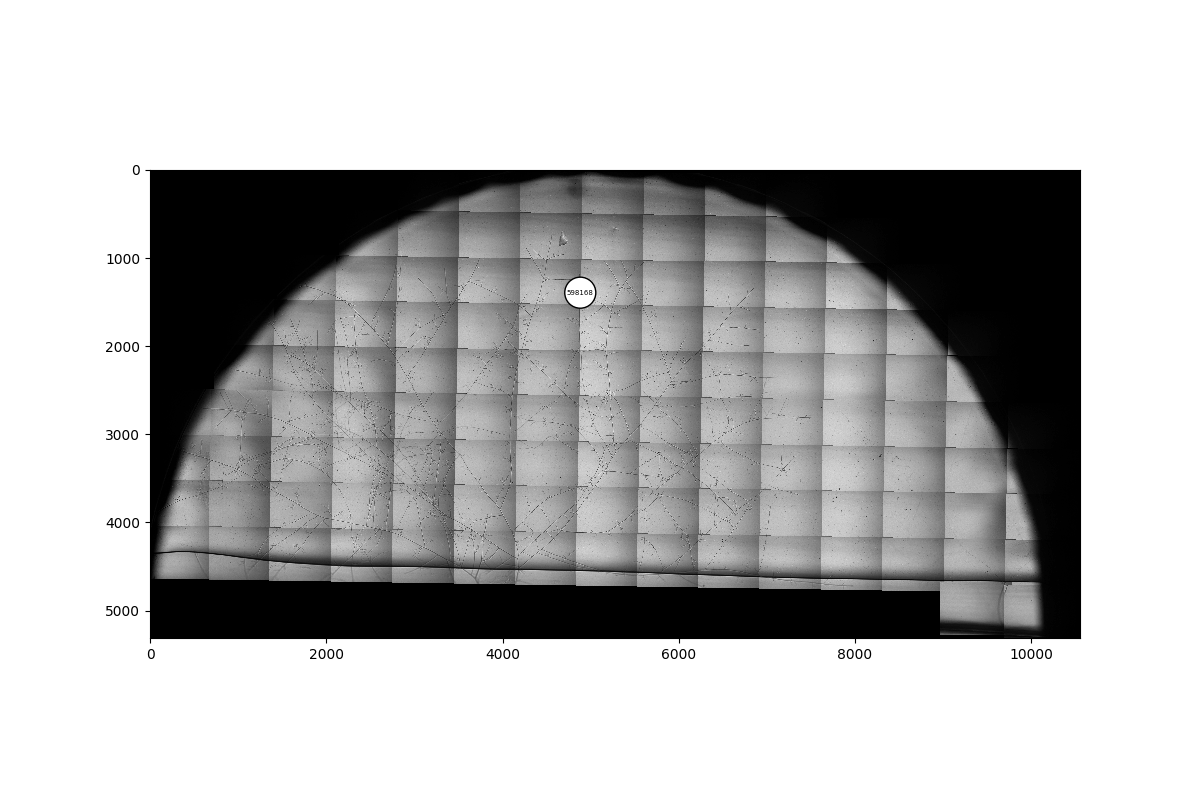

In [48]:
plt.close("all")
ax = plot_full_image_with_features(
    exp,
    tf,
    nodes=junctions_found_tf
    # nodes = [Node(607965,exp),Node(518481,exp)]
)

In [18]:
t = 50
nodes = get_all_nodes(exp, t)
tips = [
    node
    for node in nodes
    if node.degree(t) == 1 and node.is_in(t + 1) and len(node.ts()) > 2
]
tips = [tip for tip in tips if np.all(is_in_study_zone(tip, t, 1000, 150, False))]
max_t = 99
growing_tips = []

for tip in tips:
    timesteps = [tim for tim in tip.ts() if tim <= max_t]
    tim = timesteps[-1] if len(timesteps) > 0 else tip.ts[-1]
    if np.linalg.norm(tip.pos(tim) - tip.pos(t)) >= 40:
        growing_tips.append(tip)


growing_rhs = [
    node
    for node in growing_tips
    if np.linalg.norm(node.pos(node.ts()[0]) - node.pos(min(node.ts()[-1], 99))) >= 0
]

# growing_rhs = [
#     node
#     for node in growing_tips
#     if f(node.edges(node.ts()[-1])[0])>=10
# ]
new_tips = [tip for tip in growing_tips if tip.ts()[0] == t]
new_tips

[Node(528566),
 Node(527712),
 Node(528453),
 Node(528442),
 Node(528452),
 Node(528433),
 Node(527644),
 Node(528176),
 Node(528504),
 Node(527974),
 Node(527992),
 Node(528632),
 Node(527735),
 Node(527780),
 Node(528564),
 Node(528479),
 Node(527717),
 Node(527696),
 Node(527705),
 Node(528299)]

In [25]:
tips = [
    node
    for node in nodes
    if node.degree(t) == 1 and node.is_in(t + 1) and len(node.ts()) > 2
]
tips = [tip for tip in tips if np.all(is_in_study_zone(tip, t, 1000, 150, False))]
growing_tips = []
for tip in tips:
    timesteps = [tim for tim in tip.ts() if tim <= max_t]
    tim = timesteps[-1] if len(timesteps) > 0 else tip.ts()[-1]
    if np.linalg.norm(tip.pos(tim) - tip.pos(t)) >= 40:
        growing_tips.append(tip)
new_tips = [tip for tip in growing_tips if tip.ts()[0] == t]
new_tips

[Node(528566),
 Node(527712),
 Node(528453),
 Node(528442),
 Node(528452),
 Node(528433),
 Node(527644),
 Node(528176),
 Node(528504),
 Node(527974),
 Node(527992),
 Node(528632),
 Node(527735),
 Node(527780),
 Node(528564),
 Node(528479),
 Node(527717),
 Node(527696),
 Node(527705),
 Node(528299)]

In [17]:
t = 50
new_tips = [tip for tip in growing_tips if tip.ts()[0] == t]
new_tips

[]

In [28]:
nodes = [hyph.end for hyph in list_hyph_obj] + [
    hyph.get_root(tf) for hyph in list_hyph_obj
]
# nodes = [hyph.end for hyph in list_hyph if hyph.end.is_in(tf)]

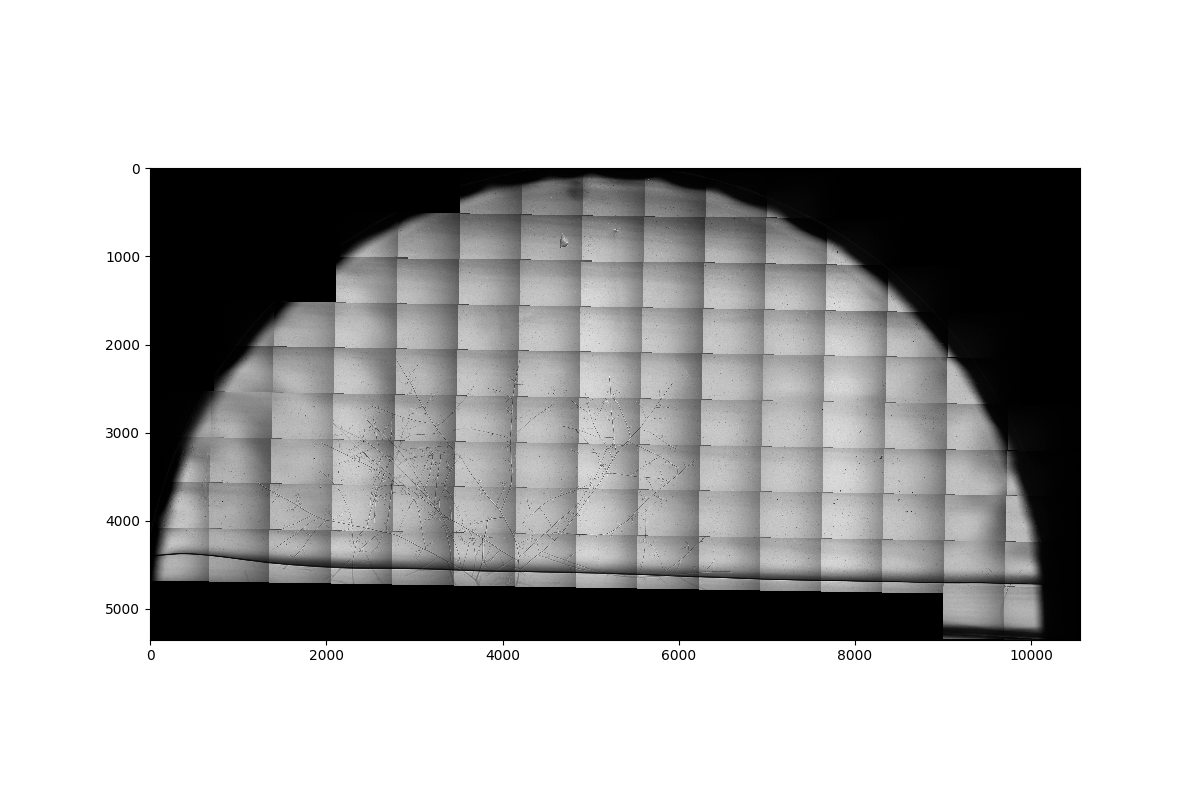

In [10]:
plt.close("all")
ax = plot_full_image_with_features(exp, t, nodes=new_tips)

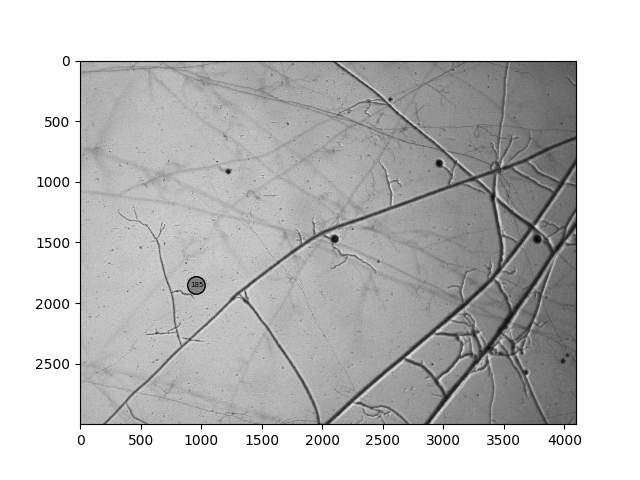

In [11]:
label = 185
Node(label, exp).show_source_image(Node(label, exp).ts()[-1])

In [31]:
Node(254, exp).ts()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159]

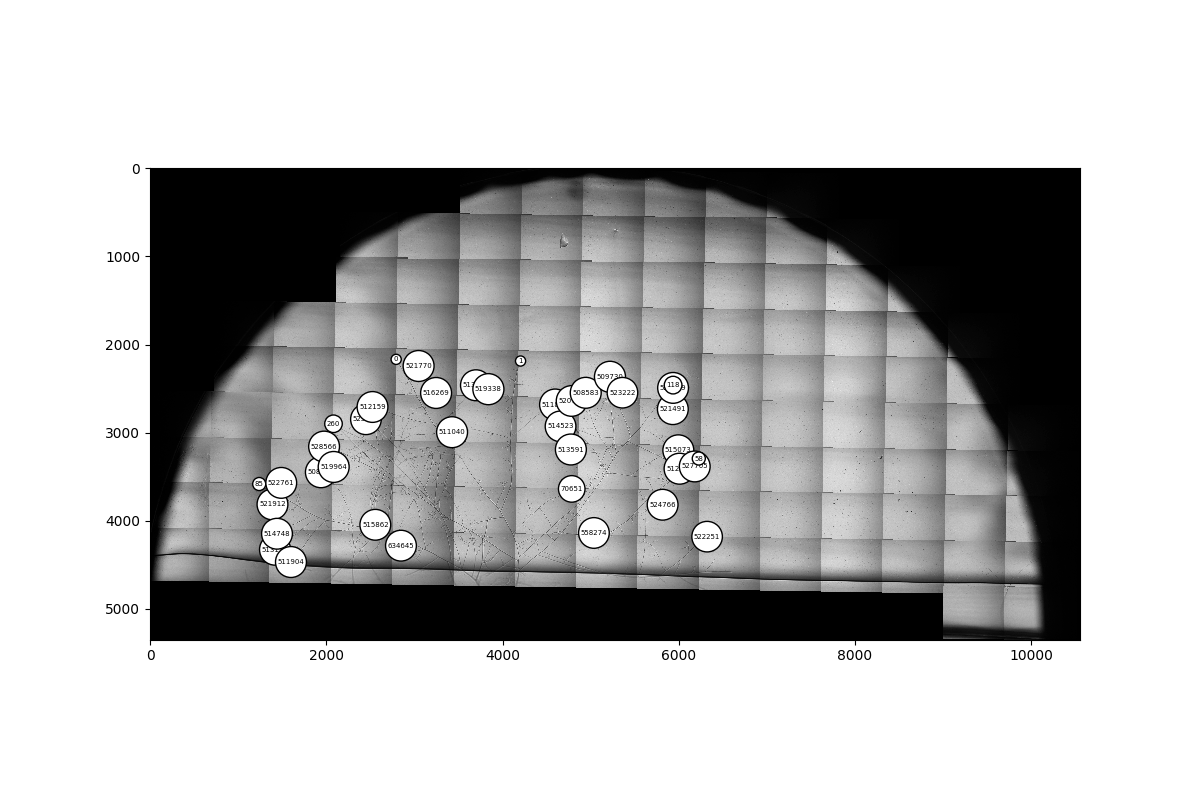

In [19]:
plt.close("all")
ax = plot_full_image_with_features(exp, t, nodes=growing_rhs)